In [0]:
import os
import glob
from google.colab import drive

drive.mount('/content/gdrive')

In [0]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/ImagesCV"

In [0]:
%cd /content/gdrive/My Drive/ImagesCV

In [0]:
from sklearn.model_selection import train_test_split
import glob
import cv2
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import torch
from matplotlib import pyplot as plt
import os
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np
import random
%matplotlib inline

## 1'st Assignment

In [0]:
students = glob.glob('/content/gdrive/My Drive/ImagesCV/*/*.*[!txt]')

In [0]:
sometimes = lambda aug : iaa.Sometimes(0.5, aug)

In [0]:
def make_augmantations(p = 1):
     return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

### Augmantations - 
Using imgaug library.

In [0]:
seq = iaa.Sequential(
    [
        iaa.SomeOf((0, 5),
            [
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                 iaa.OneOf([
                    iaa.AdditiveGaussianNoise(loc=0, scale=(4, 0.1*255), per_channel=0.5), # add gaussian noise to images
                    iaa.CoarseDropout((0.03, 0.08), size_percent=(0.02, 0.05), per_channel=0.5),
                    iaa.Dropout((0.01, 0.1), per_channel=0.6), # randomly remove up to 10% of the pixels
                ]),
                iaa.OneOf([
                    iaa.Sharpen(alpha=(0.7, 1.0), lightness=(1, 2)), # sharpen images
                    iaa.Emboss(alpha=(0.5, 1.0), strength=(1, 2.0)), # emboss images
                    iaa.LinearContrast((0.5, 2.5), per_channel=0.5), # improve or worsen the contrast
                    iaa.Grayscale(alpha=(0.0, 1.0)),
                ]),
                iaa.OneOf([
                    iaa.Fliplr(0.8), # horizontally flip 20% of all images
                    sometimes(iaa.Affine(
                    scale={"x": (0.9, 1.2), "y": (0.9, 1.2)}, # scale images to 90-120% of their size, individually per axis
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                    rotate=(-20, 20), # rotate by -20 to +20 degrees
                    shear=(-15, 15), # shear by -15 to +15 degrees
                    order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                    mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ))
                ]),
              
            ],
            random_order=True
        )
    ],
    random_order=True
)

### 1.1 Data Loader using augmantation class

In [0]:
class MyDataSet(Dataset):
    def __init__(self, paths, train = True, transform = None, size = 512):
        self.paths = paths
        self.train = train
        self.transform = transform
        self.size = size

    def __getitem__(self, idx):
        p = self.paths[idx]
        label = p.split("/")[-2]
        image = cv2.imread(p)
        image = cv2.resize(image,(self.size,self.size))
        image = cv2.cvtColor(image,(cv2.COLOR_BGR2RGB))
        if self.train :
            image = seq.augment_image(image)   
        if self.transform != None:  
            image = transforms.ToPILImage()(image)
            image= self.transform(image)

        return image, label
    
    def __len__(self):
        return len(self.paths)

In [0]:
train_transforms = make_augmantations()
test_trandforms = make_augmantations()

set1 = MyDataSet(students,transform =train_transforms,train=True)
loader = torch.utils.data.DataLoader(set1,batch_size = 16 ,shuffle=True)

In [0]:
def norm(img):
    img -=img.min()
    img/=img.max()
    return img

# *1.2* Show all data and split for test and train

load all the data paths and save it to a dictionary




In [0]:
def load_datapaths(students):
    students_dict = {}
    i = 0
    for idx in range(len(students)):
        p = students[idx]
        label = p.split("/")[-2]
        if label not in students_dict.keys():
            students_dict[label] = []
            i += 1
        students_dict[label] += [p]
    
    return students_dict

In [0]:
all_students = load_datapaths(students)

show all the data, one image of each student, with his name

In [0]:
def plot_data(students_dict): 
    i = 0
    plt.figure(figsize=[20,15])
    for label in students_dict:
        image = cv2.imread(students_dict[label][2])
        image = cv2.resize(image, (512,512))
        image = cv2.cvtColor(image, (cv2.COLOR_BGR2RGB))
        plt.subplot(5, 6, i + 1)
        plt.imshow(image, cmap = 'gray')
        plt.title(label)
        plt.axis('off')
        i +=1
    plt.show()


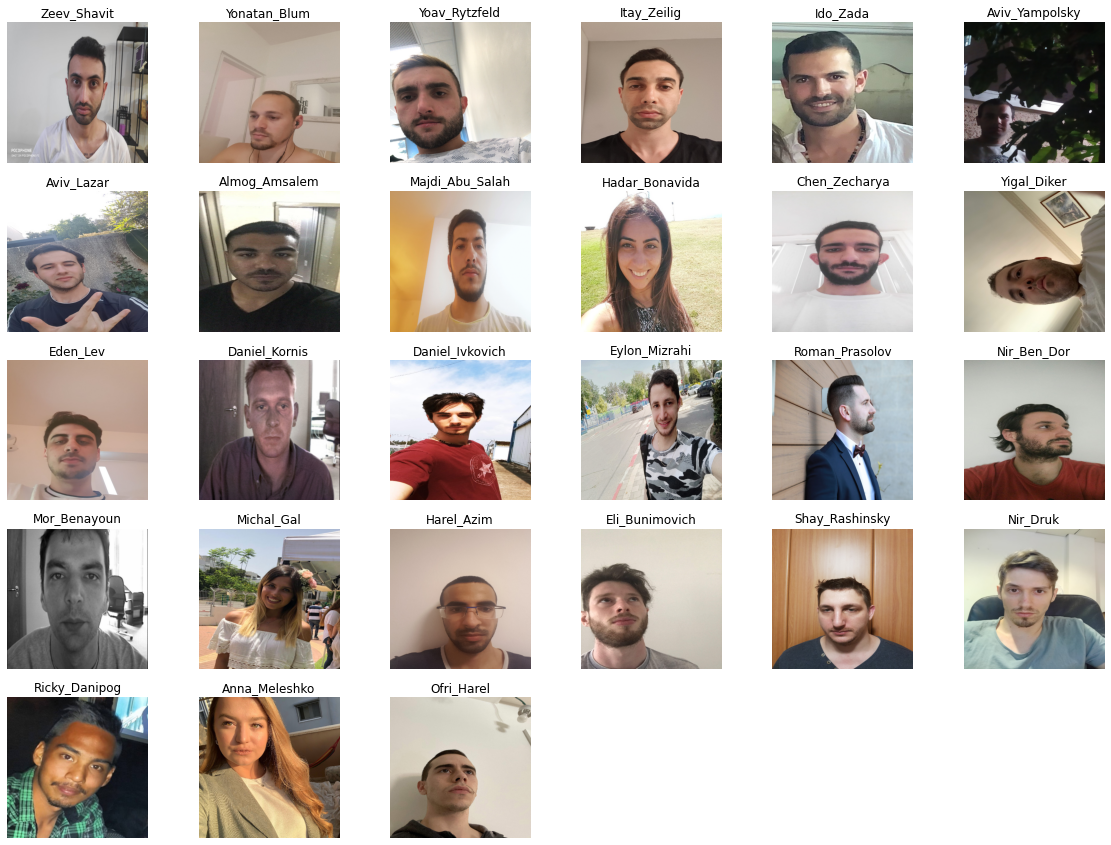

In [0]:
plot_data(all_students)

### Split the data for 80% train and 20% test

In [0]:
train_students, test_students = train_test_split(students, test_size = 0.2, random_state = 2018) #train_test spliy using sklearn

function that applies augmantation on images and plot them

In [0]:
def apply_aug_on_img(seq1,students_dict): 
    plt.figure(figsize=[10,5])
    student_lst = list(students_dict.keys())
    for i in range(0,3):
        rand1 = random.randint(0,23)
        rand2 = random.randint(0,18)
        image = cv2.imread(students_dict[student_lst[rand1+ i]][rand2])
        image = cv2.resize(image, (512,512))
        image = cv2.cvtColor(image, (cv2.COLOR_BGR2RGB))
        plt.subplot(2, 3, i + 1)
        plt.imshow(image, cmap = 'gray')
        plt.axis('off')
        plt.title(student_lst[rand1 + i])
        new_img = image.copy()
        new_img = seq.augment_image(new_img)   
        plt.subplot(2, 3, i + 4)
        plt.imshow(new_img, cmap = 'gray')       
        plt.axis('off')
        plt.title("Image after aug")

    plt.show()

##1.3 Explanation about Augmantations


### Augmantation - 
Data plays a central role, as
the performance of the deep neural network heavily depends
on the amount and quality of the training data.
To compensate the insufficient facial training data, data
augmentation provides an effective alternative, which we call
”face data augmentation”.
The direct motivation for face data augmentation is to
overcome the limitation of existing data.
It is a technology to enlarge the
data size of training or testing by transforming collected real
face samples or simulated virtual face samples.
Data augmentation provides an effective alternative to compensate the insufficient facial training data.
Deep learning strongly relies on large and complex training sets to generalize well in unconstrained settings.
Collecting and labeling a large quantity of real samples is widely recognized as laborious, expensive and error-prone.
Existing datasets are still lack of variations comparing to the samples in the real world.

The generic data augmentation techniques can be divided
into two categories: geometric transformation and photometric
transformation. These methods have been adapted to various
learning-based computer vision tasks.
**Geometric transformation** alters the geometry of an image
by transferring image pixel values to new positions. This
kind of transformation includes translation, rotation, reflection,
flipping, zoomming, scaling, cropping, padding, perspective
transformation, elastic distortion, lens distortion, mirroring,
etc.

**Photometric transformation** alters the RGB channels by
shifting pixel colors to new values, and the main approaches
include color jittering, grayscaling, filtering, lighting perturbation, noise adding, vignetting, contrast adjustment, random
erasing, etc. The color jittering method includes many different
manipulations, such as inverting, adding, decreasing and multiply. The filtering method includes edge enhancement, blurring,
sharpening, embossing, etc. 

### 1.  Gaussian Blur -
add blur to the image, big value of sigma can destroy the image and add too much blur ,so it will be diffcult to recognize the face.

I decided to set it for value 3, so the image still can be recognized


# Good Values

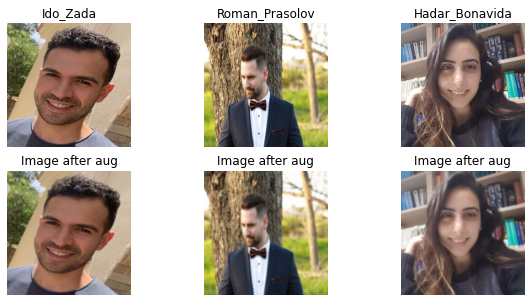

In [0]:
seq = iaa.Sequential([
   iaa.GaussianBlur((0, 3.0))
])
apply_aug_on_img(seq, all_students)

# Bad Values

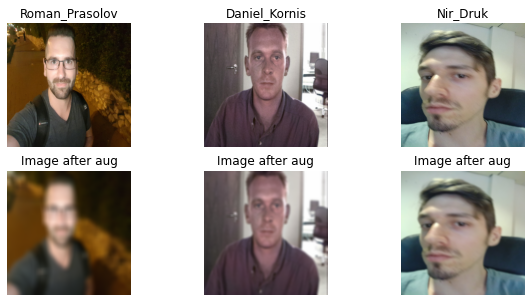

In [0]:
seq = iaa.Sequential([
   iaa.GaussianBlur((0, 15.0))
])
apply_aug_on_img(seq, all_students)

### **2**. Average Blur -
 Blur an image by computing simple means over neighbourhoods. must controll the kernel size which with big values can destroy the image.
i think that 5 is max value for the kernel, i tried 7 and it was too blur.


# Good Values

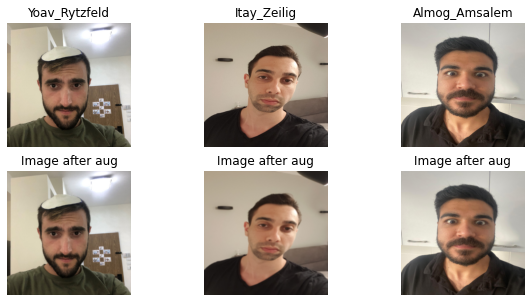

In [0]:
seq = iaa.Sequential([
  iaa.AverageBlur(k=(3,5))
])
apply_aug_on_img(seq, all_students)

# Bad Values

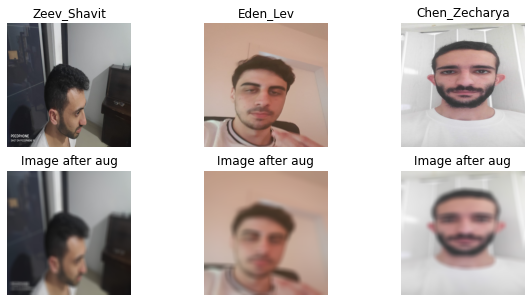

In [0]:
seq = iaa.Sequential([
  iaa.AverageBlur(k=(15,25))
])
apply_aug_on_img(seq, all_students)

### 3.Median Blur - 
Blur an image by computing median values over neighbourhoods. same as in avarge blur, we must control the k size.

# Good Values

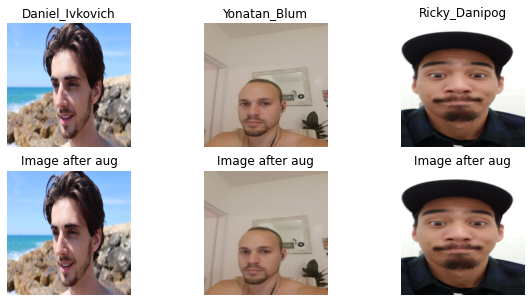

In [0]:
seq = iaa.Sequential([
  iaa.MedianBlur(k=(3, 5))
])
apply_aug_on_img(seq, all_students)

# Bad Values

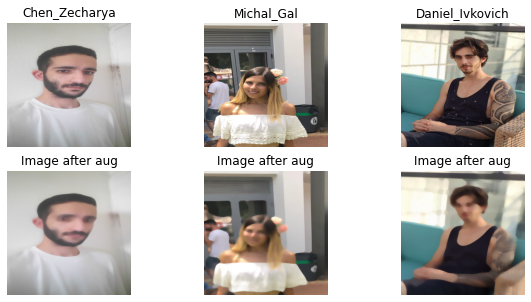

In [0]:
seq = iaa.Sequential([
  iaa.MedianBlur(k=(15,25))
])
apply_aug_on_img(seq, all_students)

### 4.Grayscale -
Changes images to grayscale versions, where number of channels is still 3.

alpha -  when a value close to 1.0 means that mostly the new grayscale image is visible. A value close to 0.0 means, that mostly the old image is visible. in our case both of the variations is good because every value of alpha not destroy our image, and the image still can be recognized.


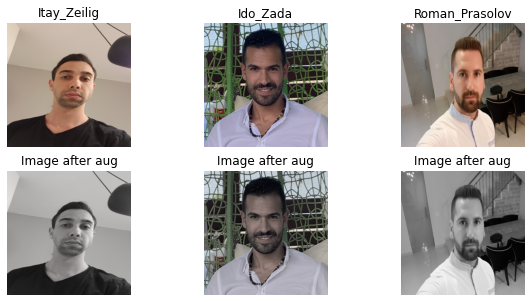

In [0]:
seq = iaa.Sequential([
  iaa.Grayscale(alpha=(0.5, 1.0))
])
apply_aug_on_img(seq, all_students)

### 5.Sharpen - 
Augmenter that sharpens images and overlays the result with the original image.

alpha - Visibility of the sharpened image. At 0, only the original image is visible, at 1.0 only its sharpened version is visible.

lightness - Parameter that controls the lightness/brightness of the sharped image.The value 0 results in an edge map. Values higher than 1 create bright images.
I think that the max value of lightness must be not more than 2, because than the image is too bright for be understandable.


# Good Values

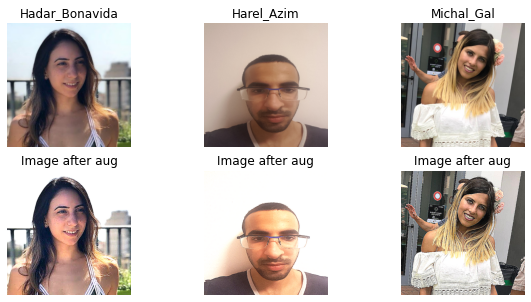

In [0]:
seq = iaa.Sequential([
  iaa.Sharpen(alpha=(0.7, 1.0), lightness=(1.0, 2.0))
])
apply_aug_on_img(seq, all_students)


# Bad Values

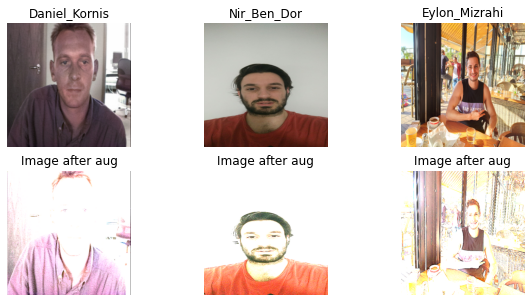

In [0]:
seq = iaa.Sequential([
  iaa.Sharpen(alpha=(0.9, 1.0), lightness=(3.0, 5.0))
])
apply_aug_on_img(seq, all_students)


### 6.Emboss - 
The embossed version pronounces highlights and shadows,
letting the image look as if it was recreated on a metal plate.

alpha - Visibility of the sharpened image. At 0, only the original image is visible, at 1.0 only its sharpened version is visible.

strength -  Parameter that controls the strength of the embossing.

# Good Values

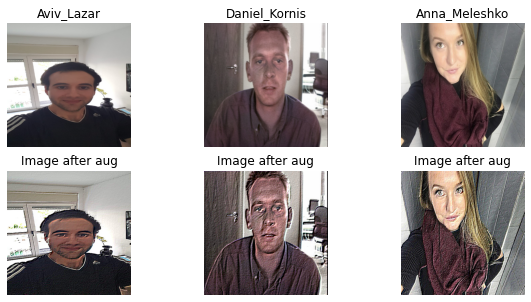

In [0]:
seq = iaa.Sequential([
  iaa.Emboss(alpha=(0.5, 1.0), strength=(1.0, 2.0))
])
apply_aug_on_img(seq, all_students)

# Bad Values

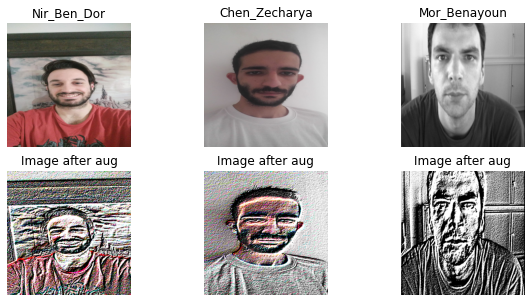

In [0]:
seq = iaa.Sequential([
  iaa.Emboss(alpha=(0.9, 1.0), strength=(15.0, 20.0))
])
apply_aug_on_img(seq, all_students)

### 7.LinearContrast -
 Adjust contrast to the image by scaling each pixel value to another value by some formule.

alpha - multiplier to linearly pronounce (>1), dampen (0.0 to 1.0) or invert (<0) the image colors.
i chose the alpha value to be max 2.5, i saw that bigger than that we get data that hard to recognize.

# Good Values

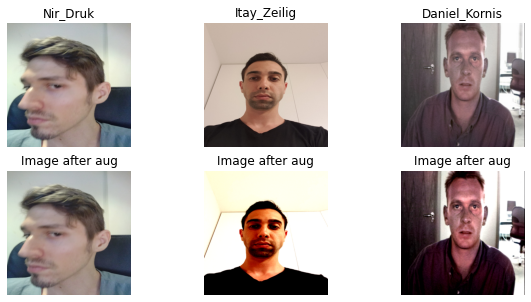

In [0]:
seq = iaa.Sequential([ 
  iaa.LinearContrast((0.5, 2.5), per_channel=0.5)
])
apply_aug_on_img(seq, all_students)

# Bad Values

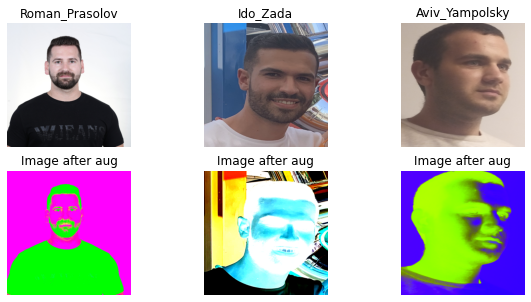

In [0]:
seq = iaa.Sequential([ 
  iaa.LinearContrast((-7.5, 7.5), per_channel=0.5)
])
apply_aug_on_img(seq, all_students)

### 8.Additive Gaussian Noise - 
Add gaussian noise (aka white noise) to images.

loc,scale - Mean or Standard deviation of the normal distribution that generates the noise.
i chose to limit the scale for 0.1*255 = 25.5 so the noise wont be so high and wont damage the image.

# Good Values

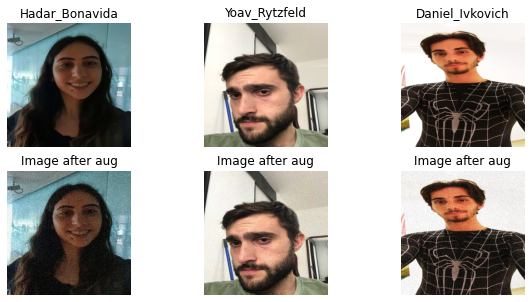

In [0]:
seq = iaa.Sequential([
    iaa.AdditiveGaussianNoise(loc=0, scale=(4, 0.1*255), per_channel=0.5)
])
apply_aug_on_img(seq, all_students)

# Bad Values

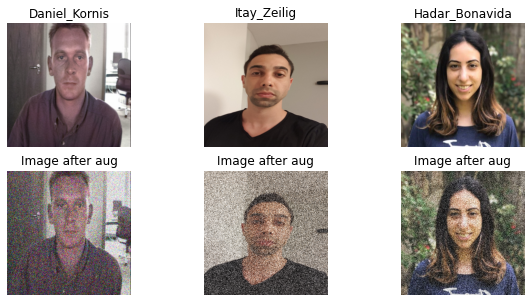

In [0]:
seq = iaa.Sequential([
    iaa.AdditiveGaussianNoise(loc=0, scale=(4, 1.5*255), per_channel=0.5)
])
apply_aug_on_img(seq, all_students)

### 9.CoarseDropout / Dropout -
Dropout is an outstanding method to improve the network’s generalization ability and test performance. Its a technique where randomly selected neurons are ignored during training. 

CoarseDropout - Augmenter that sets rectangular areas within images to zero.

Dropout - 
Augmenter that sets a certain fraction of pixels in images to zero.

p- The probability of any pixel being dropped (i.e. set to zero).
put values bigger than 0.2 make a high dropout that can damage **the** image.

# Good Values

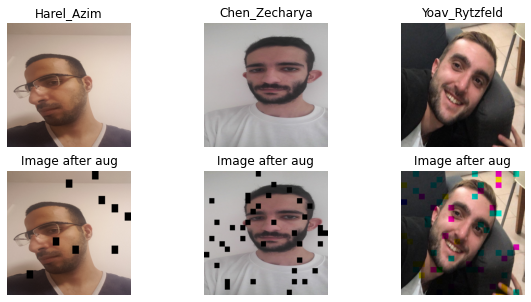

In [0]:
seq = iaa.Sequential([
    iaa.CoarseDropout((0.03, 0.08), size_percent=(0.02, 0.05), per_channel=0.6)
])
apply_aug_on_img(seq, all_students)

# Bad Values

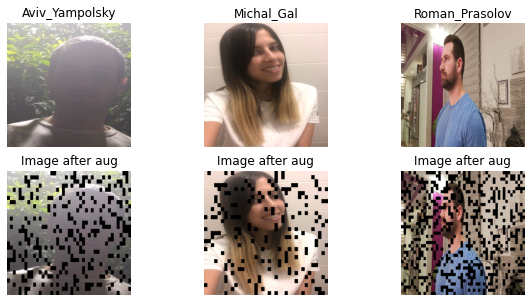

In [0]:
seq = iaa.Sequential([
    iaa.CoarseDropout((0.1, 0.5), size_percent=(0.05, 0.15), per_channel=0.2)
])
apply_aug_on_img(seq, all_students)

Dropout

# Good Values

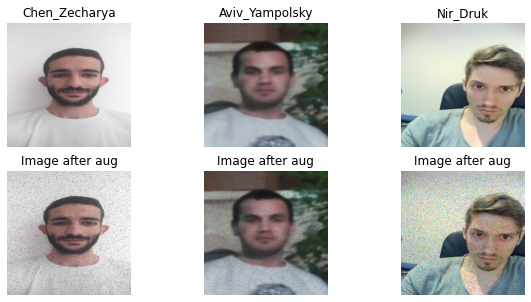

In [0]:
seq = iaa.Sequential([
    iaa.Dropout((0.01, 0.1), per_channel=0.2)
])
apply_aug_on_img(seq, all_students)


# Bad Values

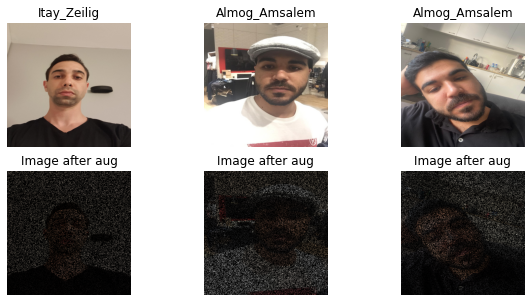

In [0]:
seq = iaa.Sequential([
    iaa.Dropout((0.8, 0.9), per_channel=0.2)
])
apply_aug_on_img(seq, all_students)


### 11.Affine - includes: Rotate, Scale, Translate percent, Shear, Order, Cval
Augmenter to apply affine transformations to images.
All such transformations can create "new" pixels in the image without a
defined content, e.g. if the image is translated to the left, pixels
are created on the right.

11.1.Rotate - helping the net to not be misleaded by rotation in an input image. values that are too big in the limit will make the image rotates too much, and can affect he learning.  

11.2.Scale - where 1.0 represents no change and 0.5 is zoomed out to 50 percent of the original size

*11.3*.Translate Percent -Translation in percent relative to the image height/width




# Good Valus

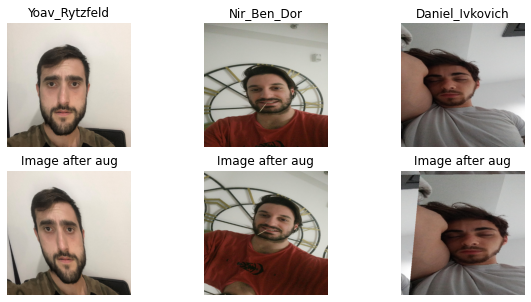

In [0]:
seq = iaa.Sequential([
    iaa.Affine(
                    scale={"x": (0.9, 1.2), "y": (0.9, 1.2)}, # scale images to 90-120% of their size, individually per axis
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                    rotate=(-20, 20), # rotate by -20 to +20 degrees
                    shear=(-15, 15), # shear by -15 to +15 degrees
                    order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                    mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )])
apply_aug_on_img(seq, all_students)


# Bad Values


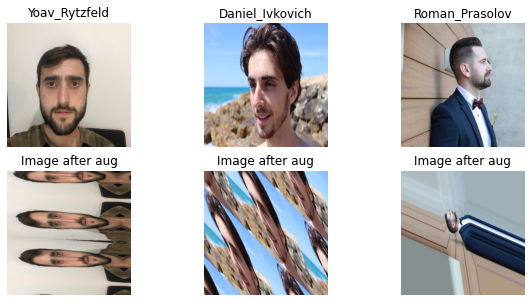

In [0]:
seq = iaa.Sequential([
    iaa.Affine(
                    scale={"x": (0.2, 1.2), "y": (0.2, 1.2)}, # scale images to 80-120% of their size, individually per axis
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                    rotate=(-150, 150), # rotate by -45 to +45 degrees
                    shear=(-80, 80), # shear by -16 to +16 degrees
                    order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                    mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )])
apply_aug_on_img(seq, all_students)

### 12.FlipLR - 
Flips the image horizontally(mirroring).
this augmantation helping the net to not be misleaded by rotation in an input image.
This augmentation not damaging the image.
In this augmantation we dont must to control the probabilty of the fliping, because in any case its doesnt damage the data.


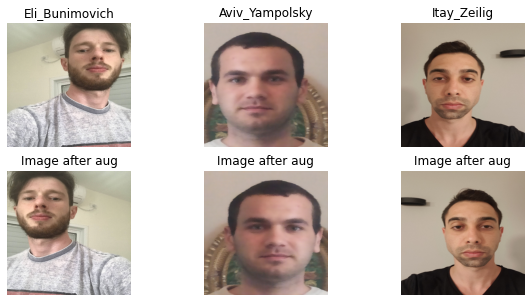

In [0]:
seq = iaa.Sequential([
    iaa.Fliplr(0.8)
 ])
apply_aug_on_img(seq, all_students)


## 1.4 Show the chosen augmantation - 
apply all augmantaions combined and plot them

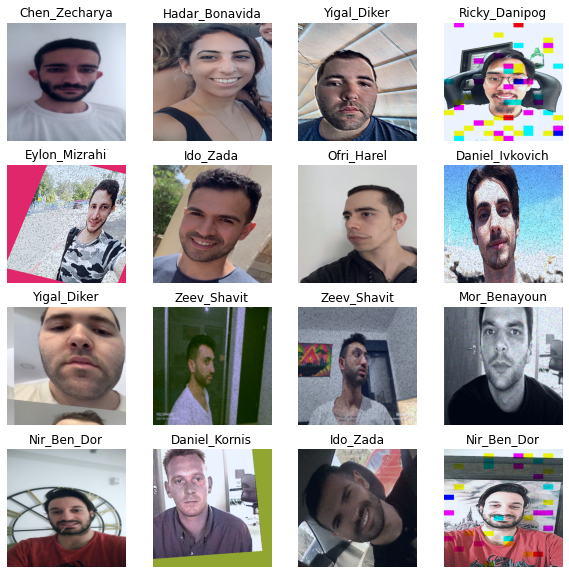

In [0]:
batch = iter(loader)
img,label = next(batch)
img = img.numpy()
label = label
plt.figure(figsize=[10, 10])
for i, (row, t) in enumerate(zip(img, label)):
    plt.subplot(4, 4, i+1)
    im = row.transpose(1, 2, 0)
    plt.imshow(norm(im))
    plt.axis('off')
    plt.title(t)
plt.show()

In [0]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
!wget https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml -O as lbfmodel.yaml

# 2nd Assignment - face swapping
In this part i used haarcascade_frontalface_default classifier, which is one of many types of cascade classifiers.
cascade classifier - its a trained classifier,and most commonly used in image processing for object detection and tracking, primarily facial detection and recognition.

the detectMultiScale() func finds all the faces in the image, where for each face we have 4 cordinates of the rectangle that wrapes the face.
sometimes this function finds small rectangles that aren't relevant for us, so for that i used the argmax function to find the biggest rectangle which have higher chnaces to be the face we are looking for.
then, i cropped the face from the first image and paste it into the seconed image where the seconed rectangle was classfied, of course after resizing the first image to the size of the seconed one. 


In [0]:
import urllib.request as urlreq
import os
import matplotlib.pyplot as plt
from pylab import rcParams

In [0]:
def face_detect_and_swap(img1,img2):
    name1 = img1.split("/")[-2] 
    name2 = img2.split("/")[-2] 
    plt.figure(figsize=[20, 10])
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    face_img = cv2.imread(img1)
    gray1 = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY) 
    body_img = cv2.imread(img2)
    gray2 = cv2.cvtColor(body_img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray1, 1.1, 4)
    faces_b = face_cascade.detectMultiScale(gray2, 1.1, 4)
    face = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    if len(faces) == 0 or len(faces_b) == 0:
        return None , None
    areas = [w*h for x,y,w,h in faces]
    faces = faces[np.argmax(areas)]
    face_x, face_y ,face_w, face_h = faces
    plt.subplot(131)
    plt.imshow(face)
    plt.title(name1)
    plt.axis('off')
    body = cv2.cvtColor(body_img, cv2.COLOR_BGR2RGB)
    body_x, body_y ,body_w, body_h = faces_b[0]
    face_img_cpy = face.copy()
    cropped_img = face_img_cpy[face_y +8: face_y + face_w - 8, face_x + 8 : face_x + face_h - 8]
    cropped_img = cv2.resize(cropped_img,(body_w + 6,body_h + 6))
    new_img = body.copy()
    new_img[body_y -2 : body_y + body_w +4 , body_x -2: body_x + body_h +4 ] = cropped_img
    plt.subplot(132)
    plt.imshow(body)
    plt.title(name2)
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(new_img)
    plt.title("Swapped")
    plt.axis('off')
    plt.show()
    return faces, faces_b

In [0]:
faces_lst = list(all_students.keys())

def show_random_faces_swap(f_list,students):
    while True:
        rand1 = random.randint(0, 19)
        rand2 = random.randint(0, 19)
        rand3 = random.randint(0, 26)
        rand4 = random.randint(0, 26)
        if rand3 != rand4:
            break
    found1, found2 = face_detect_and_swap(students[faces_lst[rand3]][rand1],students[faces_lst[rand4]][rand2])
    while found1 is None and found2 is None :
        while True:
            rand1 = random.randint(0, 19)
            rand2 = random.randint(0, 19)
            rand3 = random.randint(0, 26)
            rand4 = random.randint(0, 26)
            if rand3 != rand4:
                break
        found1, found2 = face_detect_and_swap(students[faces_lst[rand3]][rand1],students[faces_lst[rand4]][rand2])

    


Good example, but still not accurate

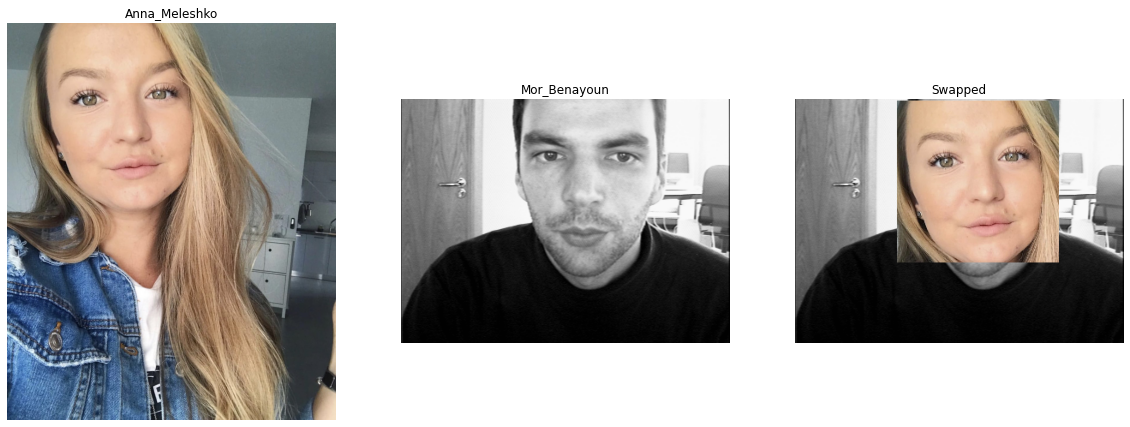

In [0]:
show_random_faces_swap(faces_lst,all_students)

Bad example

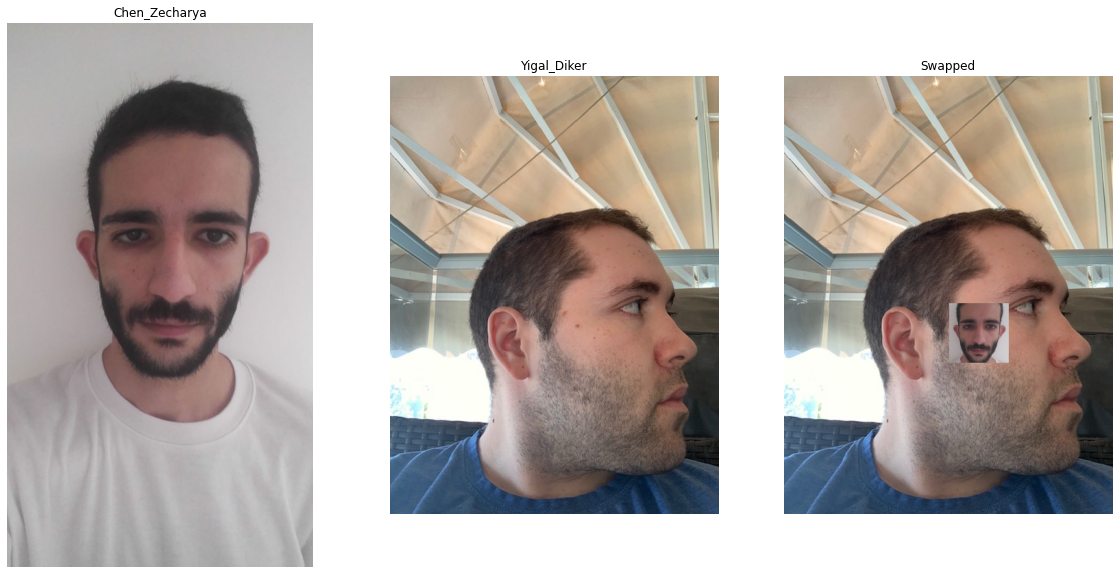

In [0]:
show_random_faces_swap(faces_lst,all_students)

# Face swapping - 2'nd way to accurate the swap

After i tried to make face swapping with the first way that uses "CascadeClassifier" thechnique, i found that it wasnt much precise and didnt classify all the faces correctly as we can see ine the examples above, so i found another way of face swapping using another model called "LBF model" which helps detect landmarks in image, and helps find eyes, nose and mouth in face image.

LBF model is helping find points facial landmarks.we can use those points and with OpenCV we can use the ConvexHull() function to get the boundary of the shape. After making the bounding we use the points to build a Delaunay Triangulation which means to build many connected traingles from the given points on the face image.
Next step is to swap each traingles of the first image with each triangle of the seconed image.To swap the triangles, each triangle must fit the size of the other triangle and in order to bulid them on the mask of the convex hull that been created for the first image, we must remove the mask of that image and than build on the new triangles.

i used a nice video that explained all the steps of this techniqe.(have 5 parts that explaining that very well - u can see the video below).


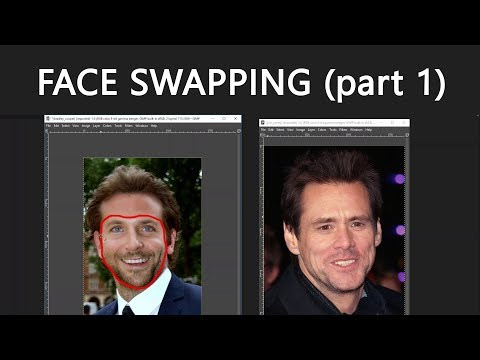

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('dK-KxuPi768')

In [0]:
def create_face_landmark_points(img):
    LBFmodel = "lbfmodel.yaml"
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    face_img = cv2.imread(img)
    gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY) 
    faces = face_cascade.detectMultiScale(gray, 1.1, 4) #finds faces points
    face = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    areas = [w*h for x,y,w,h in faces]
    faces = faces[np.argmax(areas)] #finds the biggest square
    #create an instance of the Facial landmark Detector with the model
    landmark_detector  = cv2.face.createFacemarkLBF()
    landmark_detector.loadModel(LBFmodel)
    #detect landmarks on gray image
    _, landmarks = landmark_detector.fit(gray, np.array([faces]))
    landmarks_points = []
    for landmark in landmarks:
        for x,y in landmark[0]:
            landmarks_points.append((int(x),int(y)))
            cv2.circle(face, (x, y), 1, (255, 255, 255), 3) #draw points around the eyes,nose,mouth etc.
    return landmarks_points ,gray ,face ,face_img, faces

In [0]:
def create_convex_hull(landmarks_points ,face): # to get the boundary of the face
    points = np.array(landmarks_points,dtype=np.int32)
    hull = cv2.convexHull(points)
    face = cv2.polylines(face, [hull], True, (255,0,0), 3)
    return hull, points, face

In [0]:
def create_mask(gray, face, hull): # create the mask from the boundary of the face
    mask = np.zeros_like(gray)
    cv2.fillConvexPoly(mask, hull, 255)
    face_img1 = cv2.bitwise_and(face, face, mask = mask)
    return mask, face_img1

In [0]:
def extract_index_nparray(nparray): #extract number from the array
    index = None
    for num in nparray[0]:
        index = num
        break
    return index

In [0]:
def create_triangles(hull, landmarks_pts, face, points): #draw lines between the landmark points and create triangles
    rect = cv2.boundingRect(hull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_pts)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype = np.int32)

    indexes_triangles = []
    for t in triangles: 
        pt1 = (t[0],t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
        cv2.line(face,pt1,pt2,(0,0,255), 2) #draw triangles  - need the drwaing just to show the idea
        cv2.line(face,pt2,pt3,(0,0,255), 2)
        cv2.line(face,pt1,pt3,(0,0,255), 2)
        pt1_idx = np.where((points == pt1).all(axis=1)) #have an nparray with one number for one axis
        pt1_idx = extract_index_nparray(pt1_idx) #extracting the number from the array

        pt2_idx = np.where((points == pt2).all(axis=1))
        pt2_idx = extract_index_nparray(pt2_idx)

        pt3_idx = np.where((points == pt3).all(axis=1))
        pt3_idx = extract_index_nparray(pt3_idx)

        if pt1_idx is not None and pt2_idx is not None and pt3_idx is not None:
                triangle = [pt1_idx, pt2_idx, pt3_idx]
                indexes_triangles.append(triangle) #make a list os all the triangles indexes
    return indexes_triangles

In [0]:
def wrap_triangle(p1, p2, cropped_tr2_mask, cropped_triangle, h,w):#Trasform each triangle to fit the size of the seconedr triangle
    p1 = np.float32(p1)
    p2 = np.float32(p2)
    M = cv2.getAffineTransform(p1, p2)
    wrapped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    wrapped_triangle = cv2.bitwise_and(wrapped_triangle, wrapped_triangle, mask=cropped_tr2_mask)
    return wrapped_triangle

In [0]:
def reconstruct_dest_face(wrapped_triangle, orig_img2, x, y, h, w, img2_new_face): #paste triangles one after one
    rectangle_area2 = img2_new_face[y: y + h, x: x + w]
    rectangle_area2_gray = cv2.cvtColor(rectangle_area2, cv2.COLOR_BGR2GRAY)
    _, triangles_mask = cv2.threshold(rectangle_area2_gray, 1, 255, cv2.THRESH_BINARY_INV)
    wrapped_triangle = cv2.bitwise_and(wrapped_triangle, wrapped_triangle, mask= triangles_mask)
    rectangle_area2 = cv2.add(rectangle_area2, wrapped_triangle)
    img2_new_face[y: y + h, x: x + w] = rectangle_area2
    return img2_new_face

In [0]:
def triangulation(gray ,orig_img1, orig_img2, indexes_triangles ,landmarks_pts1, landmarks_pts2):
    lines_space_mask = np.zeros_like(gray)
    height, width, channels = orig_img2.shape
    img2_new_face = np.zeros((height, width, channels), np.uint8)
    for triangle_index in indexes_triangles: # Triangulation of the first face
        tr1_pt1 = landmarks_pts1[triangle_index[0]]
        tr1_pt2 = landmarks_pts1[triangle_index[1]]
        tr1_pt3 = landmarks_pts1[triangle_index[2]]
        triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)

        rect1 = cv2.boundingRect(triangle1)
        (x, y, w, h) = rect1
        cropped_triangle = orig_img1[y: y + h, x: x + w]
        cropped_tr1_mask = np.zeros((h, w), np.uint8)

        points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                           [tr1_pt2[0] - x, tr1_pt2[1] - y],
                           [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)
        cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

        cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
        cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
        cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
        lines_space = cv2.bitwise_and(orig_img1, orig_img1, mask=lines_space_mask)

        tr2_pt1 = landmarks_pts2[triangle_index[0]] # Triangulation of second face
        tr2_pt2 = landmarks_pts2[triangle_index[1]]
        tr2_pt3 = landmarks_pts2[triangle_index[2]]
        triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)

        rect2 = cv2.boundingRect(triangle2)
        (x, y, w, h) = rect2

        cropped_tr2_mask = np.zeros((h, w), np.uint8)
        points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                            [tr2_pt2[0] - x, tr2_pt2[1] - y],
                            [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)
        cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)
        wrapped_triangle = wrap_triangle(points, points2, cropped_tr2_mask, cropped_triangle, h, w)
        img2_new_face = reconstruct_dest_face(wrapped_triangle, orig_img2, x, y, h, w, img2_new_face)
    return img2_new_face

In [0]:
def swap_faces(gray2, convex_hull2, orig_img2, img2_new_face): # Face swapping putting 1st face into 2nd face
    img2_face_mask = np.zeros_like(gray2)
    img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convex_hull2, 255)
    img2_face_mask = cv2.bitwise_not(img2_head_mask)

    img2_head_noface = cv2.bitwise_and(orig_img2, orig_img2, mask=img2_face_mask)
    result = cv2.add(img2_head_noface, img2_new_face)

    (x, y, w, h) = cv2.boundingRect(convex_hull2)
    center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

    seamlessclone = cv2.seamlessClone(result, orig_img2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)
    new_img = cv2.cvtColor(seamlessclone, cv2.COLOR_RGB2BGR) 
    plt.imshow(new_img)
    plt.title('After Swapping')
    plt.axis('off')

In [0]:
def apply_swap_on_images(img1,img2):
    #face1 
    plt.figure(figsize=[20, 10])
    landmarks_pts1, gray1, face1 , origin_img1, faces1 = create_face_landmark_points(img1)
    convex_hull1, points1, face_hull1 = create_convex_hull(landmarks_pts1, face1)
    mask1, f_img1 = create_mask(gray1, face1, convex_hull1)
    indexes_triangles1 = create_triangles(convex_hull1, landmarks_pts1, face1, points1)
    origin_img11 = origin_img1.copy()
    origin_img11 = cv2.cvtColor(origin_img11 , cv2.COLOR_RGB2BGR)
    plt.subplot(2,4,1)
    plt.title('Original face 1')
    plt.axis('off')
    plt.imshow(origin_img11)
    plt.subplot(2,4,2)
    plt.title('Find triangles ')
    plt.axis('off')
    plt.imshow(face_hull1)
    plt.subplot(2,4,3)
    plt.title('Create Mask ')
    plt.axis('off')
    plt.imshow(mask1,cmap = 'gray')
    plt.subplot(2,4,4)
    plt.title('insert face ')
    plt.axis('off')
    plt.imshow(f_img1)
    #face2 
    landmarks_pts2, gray2, face2, origin_img2, faces2 = create_face_landmark_points(img2)
    convex_hull2, points2, face_hull2= create_convex_hull(landmarks_pts2, face2)
    mask2,f_img2 = create_mask(gray2, face2, convex_hull2)
    indexes_triangles2 = create_triangles(convex_hull2, landmarks_pts2, face2, points2)
    origin_img22 = origin_img2.copy()
    origin_img22 = cv2.cvtColor(origin_img22 , cv2.COLOR_RGB2BGR)
    plt.subplot(2,4,5)
    plt.title('Original face 2')
    plt.axis('off')
    plt.imshow(origin_img22)
    plt.subplot(2,4,6)
    plt.title('Find triangles')
    plt.axis('off')
    plt.imshow(face_hull2)
    plt.subplot(2,4,7)
    plt.title('Create Mask ')
    plt.axis('off')
    plt.imshow(mask2, cmap = 'gray')
    plt.subplot(2,4,8)
    plt.title('insert face ')
    plt.imshow(f_img2)
    plt.axis('off')
    plt.show()
    #triangulation
    im2_new_f = triangulation(gray1 ,origin_img1, origin_img2, indexes_triangles1 ,landmarks_pts1, landmarks_pts2)
    swap_faces(gray2, convex_hull2, origin_img2, im2_new_f)
    return faces1, faces2

Very good example of swapping!

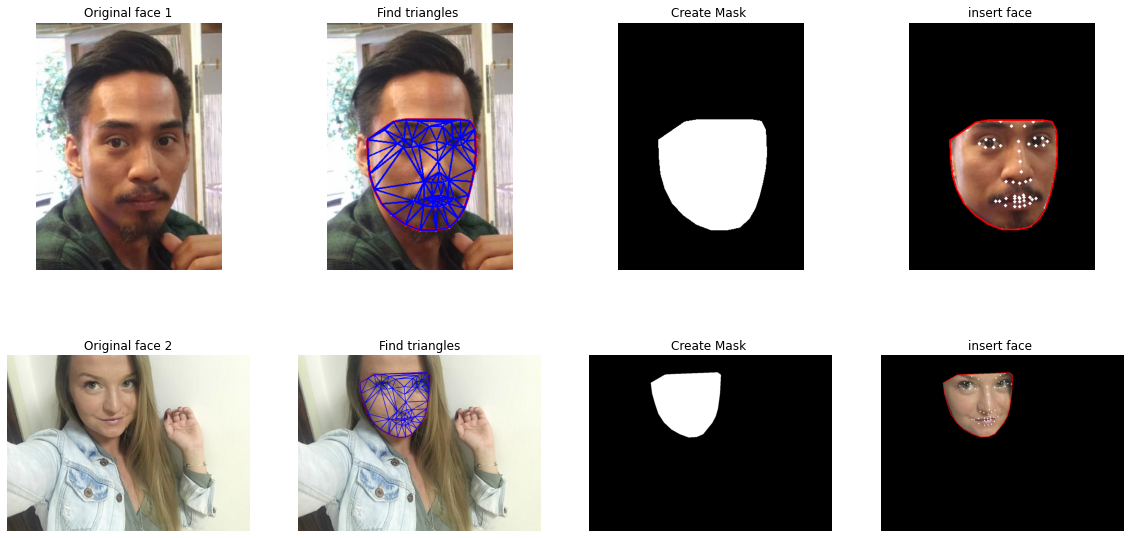

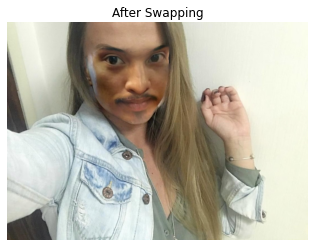

In [0]:
_, _ = apply_swap_on_images('/content/gdrive/My Drive/ImagesCV/Ricky_Danipog/IMG-20171201-WA0055.jpg','/content/gdrive/My Drive/ImagesCV/Anna_Meleshko/IMG_3432.jpg')

## Swap random faces 

In [0]:
faces_lst = list(all_students.keys())

def show_random_new_faces_swap(f_list,students):
    while True:
        rand1 = random.randint(0, 19)
        rand2 = random.randint(0, 19)
        rand3 = random.randint(0, 26)
        rand4 = random.randint(0, 26)
        if rand3 != rand4:
            break
    found1, found2 = apply_swap_on_images(students[faces_lst[rand3]][rand1],students[faces_lst[rand4]][rand2])
    while found1 is None and found2 is None :
        while True:
            rand1 = random.randint(0, 19)
            rand2 = random.randint(0, 19)
            rand3 = random.randint(0, 26)
            rand4 = random.randint(0, 26)
            if rand3 != rand4:
                break
        found1, found2 = apply_swap_on_images(students[faces_lst[rand3]][rand1],students[faces_lst[rand4]][rand2])


Good example

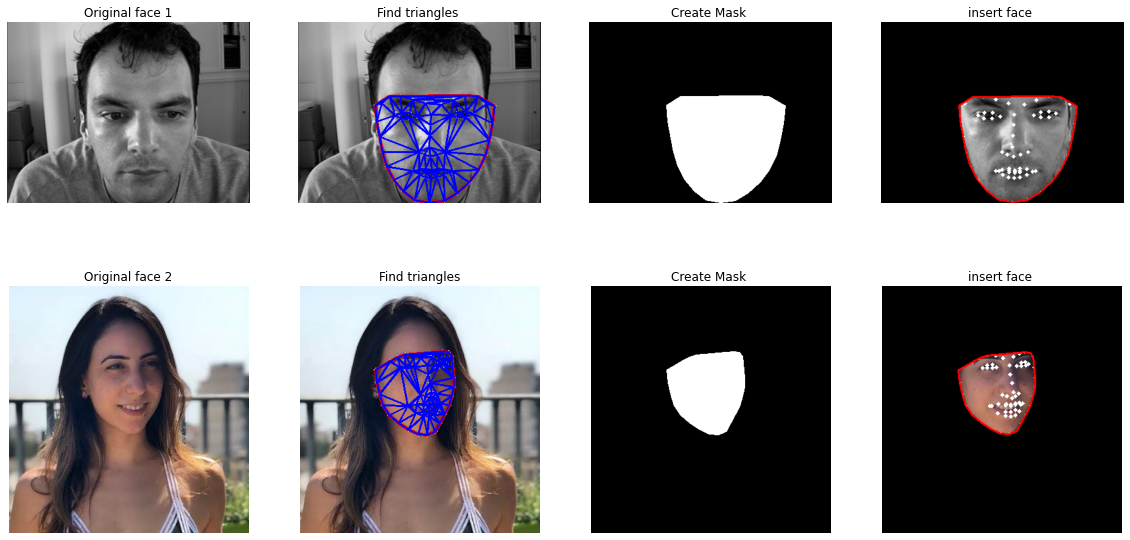

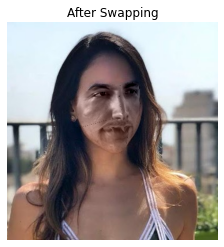

In [0]:
show_random_new_faces_swap(faces_lst,all_students)

More examples of swapping

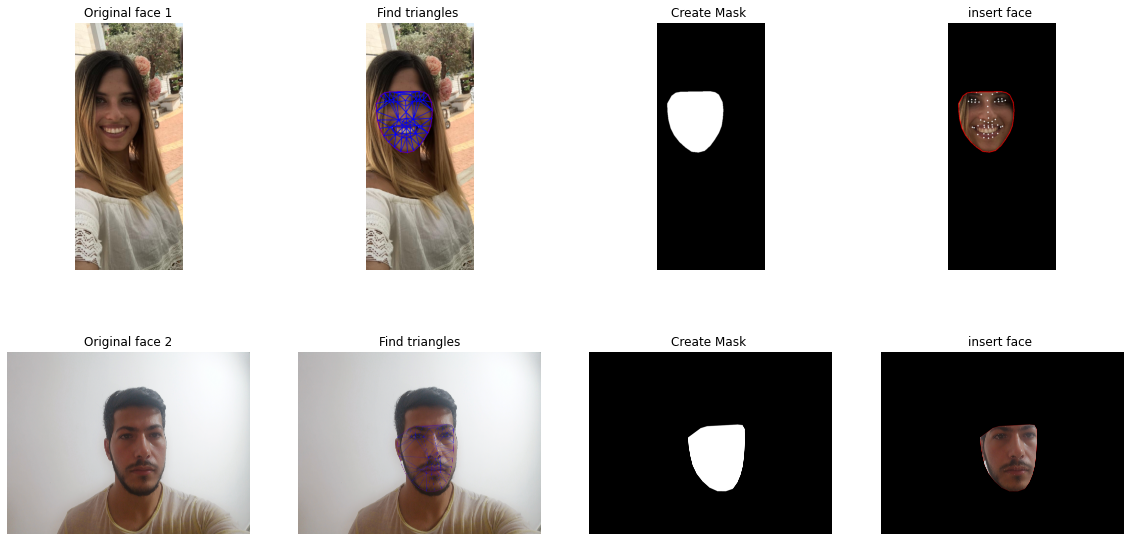

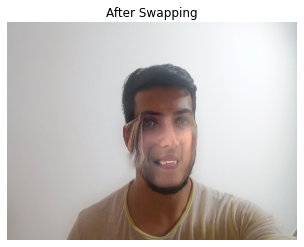

In [0]:
show_random_new_faces_swap(faces_lst,all_students)

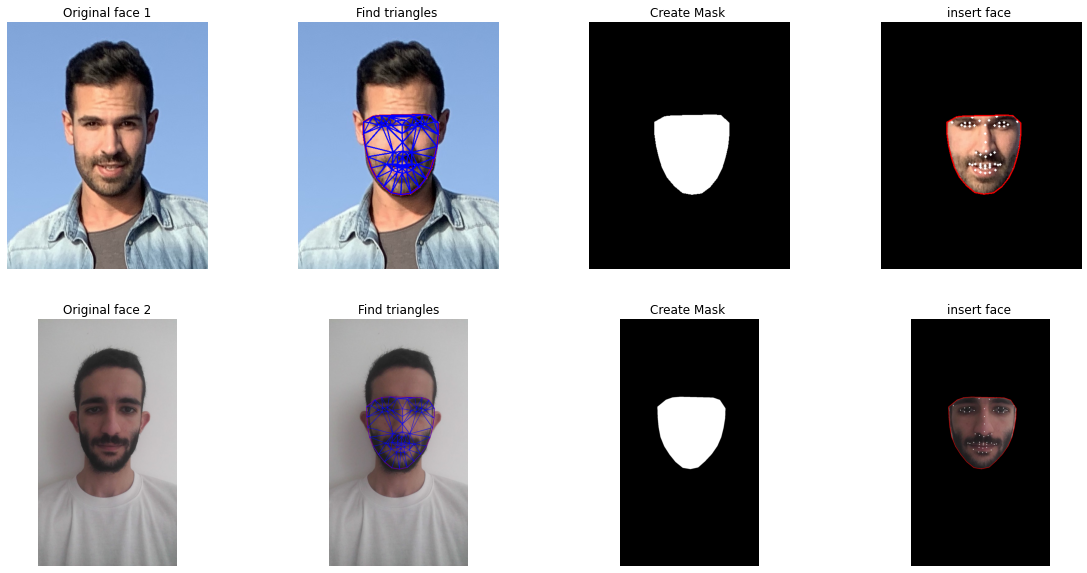

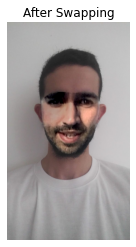

In [0]:
show_random_new_faces_swap(faces_lst,all_students)

# 3.final report -summarize all the work
In this part i will explain about all parts of the assignment.
1. 1'st part - DataLoader
2. 2'nd part - face swapping
2. 3'rd part  - Summary

1.DataLoader - In this part i built a students dataset class, the class called "MyDataSet" and this class using augmantations, i chose to use imgaug library, and explained above about all the augmantations that i used and why i chose them, i made those disicions after i ran some augmantations with diffrent paramteres and limitations to better understand which prarmeters is best for our dataset and show examples of good and bad paramaters for the augmantations.
The augmantations were selcted from [https://github.com/aleju/imgaug](https://github.com/aleju/imgaug). 
after choosing the augmantations i created the data loader and the dataset, and showed the selected augmantations on single batch.
as well i used the train_test_split function of sklearn library to split the dataset for traing and test.

2.Face swapping - In this part i useed dcascade classifier - its a trained classifiers ,and most commonly used in image processing for object detection and tracking, primarily facial detection and recognition .
i used the type of haarcascade_frontalface_default classifier, which is one of many types of cascade classifiers. 

the detectMultiScale() func finds all the faces in the image, where for each face we have 4 cordinates of the rectangle that wrapes the face. sometimes this function finds small rectangles that aren't relevant for us, so for that i used the argmax function to find the biggest rectangle which have higher chnaces to be the face we are looking for. then, i cropped the face from the first image and paste it into the seconed image where the seconed rectangle was classfied, of course after resizing the first image to the size of the seconed one.

After i tried to make face swapping with this way that uses "CascadeClassifier" thechnique, i found that it wasnt much precise and didnt classify all the faces correctly, so i found another way of face swapping using another model called "LBF model" which helps detect landmarks in image, and helps find eyes, nose and mouth in face image.

LBF model is helping find points facial landmarks.we can use those points and with OpenCV we can use the ConvexHull() function to get the boundary of the shape. After making the bounding we use the points to build a Delaunay Triangulation which means to build many connected traingles from the given points on the face image.
Next step is to swap each traingles of the first image with each triangle of the seconed image.To swap the triangles, each triangle must fit the size of the other triangle and in order to bulid them on the mask of the convex hull that been created for the first image, we must remove the mask of that image and than build on the new triangles.

References:
[https://arxiv.org/pdf/1904.11685.pdf](https://arxiv.org/pdf/1904.11685.pdf)

[https://github.com/aleju/imgaug](https://github.com/aleju/imgaug)

[https://github.com/kurnianggoro/GSOC2017/](https://github.com/kurnianggoro/GSOC2017/)

[https://www.youtube.com/watch?v=4pu54BDXYw8](https://www.youtube.com/watch?v=4pu54BDXYw8)


